In [1]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
import torch
import pandas as pd

dataset = ImageFolder('C:/Users/ambik/Documents/ReactProjects/globify/Animals_CNN/mammals', transform=ToTensor())


C:\Users\ambik\AppData\Local\Temp\ipykernel_1544\2145722851.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import matplotlib.pyplot as plt

def show_image(num):
  img, label  = dataset[num]

  plt.title(f'Label {dataset.classes[label]} ({label})' )
  plt.imshow(img.numpy().transpose(1, 2, 0))

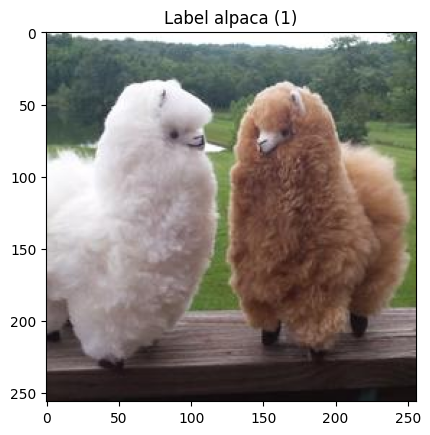

In [3]:
show_image(537)

In [4]:
len(dataset.classes)

45

In [6]:
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image


train_length = int(0.8 * len(dataset))
test_length = len(dataset) - train_length

resize_transform = transforms.Resize((64, 64))

to_tensor_transform = transforms.ToTensor()

composed_transform = transforms.Compose([resize_transform, to_tensor_transform])

train_set, test_set = random_split(dataset, [train_length, test_length])

print(train_length, "\n", test_length)


11000 
 2751


In [7]:
train_data = DataLoader(train_set, batch_size=32, shuffle=True)

test_data = DataLoader(test_set, batch_size=32, shuffle=True)

In [14]:
import torch.nn as nn

class MammalsCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.act = nn.LeakyReLU(0.1)
    self.maxpool = nn.MaxPool2d(2,2)

    self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
    self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

    self.adapt = nn.AdaptiveAvgPool2d((1,1))
    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear(64, 45)

    self.dropout = nn.Dropout(p=0.5)


  def forward(self,x):
    out = self.conv0(x)
    out = self.act(out)
    out = self.dropout(out)

    out = self.maxpool(out)

    out = self.conv1(out)
    out = self.act(out)
    out = self.dropout(out)

    out = self.maxpool(out)

    out = self.adapt(out)
    out = self.flatten(out)

    out = self.linear1(out)
    out = self.act(out)
    out = self.dropout(out)



    return out

In [15]:
model = MammalsCNN()

In [16]:
model

MammalsCNN(
  (act): LeakyReLU(negative_slope=0.1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adapt): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=45, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [20]:

for epoch in range(7):
    model.train()
    total_loss = 0.0

    with tqdm(train_data, desc=f'Epoch {epoch+1}/{7}', unit='batch') as t:
        for batch_idx, (data, target) in enumerate(t):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            t.set_postfix(loss=f'{loss.item():.7f}')

    average_loss = total_loss / len(train_data)
    print(f'Epoch [{epoch+1}/{7}], Average Loss: {average_loss:.7f}')

Epoch 1/7:   0%|          | 0/344 [00:04<?, ?batch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32 and 64x45)

In [19]:
model.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0

criterion = nn.CrossEntropyLoss()

with torch.no_grad(), tqdm(total=len(test_data), desc='Testing', unit='batch') as t:
    for data, target in test_data:
        output = model(data)
        loss = criterion(output, target)

        test_loss += loss.item()


        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()

        total_samples += target.size(0)
        t.update(1)

average_test_loss = test_loss / len(test_data.dataset)
accuracy = correct_predictions / total_samples

print(f'Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

Testing:   0%|          | 0/86 [00:01<?, ?batch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32 and 64x45)